# Ladder Sampling on 2D Ising Triangle Lattice with Numba acceleration
##  seconds used for 1E6 steps of Ladder Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [2]:
import copy
import time

In [3]:
import numba as nb

In [4]:
### fix the random seed
seed = 0
np.random.seed(seed)

-----------

In [5]:
global grid, dims, beta, j, h, delta

In [6]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grid, dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.int8(beta_init), nb.int8(j_init), nb.int8(h_init)
    grid = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                        size=dims_init[0]*dims_init[1]), dims_init)

In [7]:
### initialize the parameters
dims_init = (4, 4)
beta_init, j_init, h_init = 100, 1, 0

In [8]:
parameters_init(dims_init, beta_init, j_init, h_init)

--------------

In [9]:
types_neibors_get = nb.int8[:, :](nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibors_get)
def neibors_get(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    neibors_array = np.zeros((6, 2), dtype=np.int8)
    neibors_array[0] = np.array([height_index, nb.int8((width_index - 1) % width)])
    neibors_array[1] = np.array([height_index, nb.int8((width_index + 1) % width)])
    neibors_array[2] = np.array([nb.int8((height_index - 1) % height), width_index])
    neibors_array[3] = np.array([nb.int8((height_index + 1) % height), width_index])          
    neibors_array[4] = np.array([nb.int8((height_index - 1) % height), 
                                 nb.int8((width_index + 1) % width)])
    neibors_array[5] = np.array([nb.int8((height_index + 1) % height), 
                                 nb.int8((width_index - 1) % width)])
    return neibors_array

In [10]:
neibors_array_u = neibors_get((1, 2))
neibors_array_d = neibors_get((2, 2))

In [11]:
type_energy_get_func = nb.int16(nb.int8[:, :], nb.int8[:, :], nb.int8[:, :], nb.int8[:])
@nb.njit(type_energy_get_func)
def energy_get_nodes(grid, neibors_u, neibors_d, spins_ud):
    energy = 0
    spin_u, spin_d = spins_ud
    for id_neibor in neibors_u:
        energy += -j * spin_u * grid[id_neibor[0]][id_neibor[1]]
    for id_neibor in neibors_d:
        energy += -j * spin_d * grid[id_neibor[0]][id_neibor[1]]
    return energy

In [12]:
energy = energy_get_nodes(grid, neibors_array_u, neibors_array_d, np.array([1, -1], dtype=np.int8))

In [13]:
type_message_on_node_fun = nb.float64[:](nb.int8[:, :], nb.int8[:, :], nb.int8[:, :])
def message_on_node(grid, neibors_u, neibors_d):
    spins_uu, spins_ud = np.array([1, 1], dtype=np.int8), np.array([1, -1], dtype=np.int8)
    spins_du, spins_dd = np.array([-1, 1], dtype=np.int8), np.array([-1, -1], dtype=np.int8)
    energy_uu = energy_get_nodes(grid, neibors_u, neibors_d, spins_uu)
    energy_ud = energy_get_nodes(grid, neibors_u, neibors_d, spins_ud)
    energy_du = energy_get_nodes(grid, neibors_u, neibors_d, spins_du)
    energy_dd = energy_get_nodes(grid, neibors_u, neibors_d, spins_dd)
    message = np.array([np.exp(-beta * energy_uu), 
                        np.exp(-beta * energy_ud),
                        np.exp(-beta * energy_du), 
                        np.exp(-beta * energy_dd)])
    return message 

In [14]:
message = message_on_node(grid, neibors_array_u, neibors_array_d)

In [15]:
type_energy_get_func = nb.int32(nb.int8[:, :], nb.int8[:, :], nb.int8[:, :], nb.int8[:])
@nb.njit(type_energy_get_func)
def energy_get_pair_nodes(grid, neibors_u, neibors_d, spins_ud):
    energy = 0
    spin_u, spin_d = spins_ud
    for id_neibor in neibors_u:
        energy += -j * spin_u * grid[id_neibor[0]][id_neibor[1]]
    for id_neibor in neibors_d:
        energy += -j * spin_d * grid[id_neibor[0]][id_neibor[1]]
    energy += -j * h * spin_d
    energy += -j * h * spin_u
    energy += -j * spin_u * spin_d
    return energy

In [16]:
energy = energy_get_pair_nodes(grid, neibors_array_u, neibors_array_d, np.array([1, 1], dtype=np.int8))

In [17]:
type_message_on_pair_nodes_func = nb.float64[:](nb.int8[:, :], nb.int8[:, :], nb.int8[:, :])
@nb.njit(type_message_on_pair_nodes_func)
def message_on_pair_nodes(grid, neibors_u, neibors_d):
    spins_uu, spins_ud = np.array([1, 1], dtype=np.int8), np.array([1, -1], dtype=np.int8)
    spins_du, spins_dd = np.array([-1, 1], dtype=np.int8), np.array([-1, -1], dtype=np.int8)
    energy_uu = energy_get_pair_nodes(grid, neibors_u, neibors_d, spins_uu)
    energy_ud = energy_get_pair_nodes(grid, neibors_u, neibors_d, spins_ud)
    energy_du = energy_get_pair_nodes(grid, neibors_u, neibors_d, spins_du)
    energy_dd = energy_get_pair_nodes(grid, neibors_u, neibors_d, spins_dd)
    message = np.array([np.exp(-beta * energy_uu), np.exp(-beta * energy_ud),
                        np.exp(-beta * energy_du), np.exp(-beta * energy_dd)])
    return message

In [18]:
message = message_on_pair_nodes(grid, neibors_array_u, neibors_array_d)

In [19]:
type_message_compute_one_row_func = nb.float64[:](nb.int8[:], nb.int8[:, :])
@nb.njit(type_message_compute_one_row_func)
def message_compute_one_row(spins_left, spins_right_array):
    """
    Args:
        spins_left: (np.array)
        spins_right_array: (np.array) 
                
    Returns:
        left_right_row: (np.array)
    """
    spin_lu, spin_ld = spins_left
    left_right_array = np.zeros(spins_right_array.shape[0])
    for i, spins_right in enumerate(spins_right_array):
        energy_total = 0
        spin_ru, spin_rd = spins_right
        energy_total += -j * spin_lu * spin_ru
        energy_total += -j * spin_ld * spin_rd
        energy_total += -j * spin_ld * spin_ru
        left_right_array[i] = np.exp(-beta * energy_total)
    return left_right_array

In [20]:
spins_right_array = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]], dtype=np.int8)

In [21]:
message_compute_one_row(np.array([-1, 1], dtype=np.int8), spins_right_array)

array([2.68811714e+43, 3.72007598e-44, 2.68811714e+43, 3.72007598e-44])

In [22]:
type_message_on_edge_func = nb.float64[:, :]()
@nb.njit(type_message_on_edge_func)
def message_on_edge():
    """
    Args:
        edge: (tuple) (node_start, node_end)
            
    Returns:
        message: (np.array) 4x4 matrix
    """
    spins_left_array = np.array([(1, 1), (1, -1), (-1, 1), (-1, -1)], dtype=np.int8)
    spins_right_array = np.array([(1, 1), (1, -1), (-1, 1), (-1, -1)], dtype=np.int8)
    message_array = np.zeros((4, 4), dtype=np.float64)
    for i, spins_left in enumerate(spins_left_array):
        message_array[i] = message_compute_one_row(spins_left, spins_right_array)
    return message_array

In [23]:
message_on_edge()

array([[1.94242640e+130, 2.68811714e+043, 3.72007598e-044,
        5.14820022e-131],
       [3.72007598e-044, 2.68811714e+043, 3.72007598e-044,
        2.68811714e+043],
       [2.68811714e+043, 3.72007598e-044, 2.68811714e+043,
        3.72007598e-044],
       [5.14820022e-131, 3.72007598e-044, 2.68811714e+043,
        1.94242640e+130]])

In [24]:
type_dict_filter_func = nb.int8[:, :](nb.int8[:, :], nb.int8[:])
@nb.njit(type_dict_filter_func)
def dict_filter(neibors_array, index_array):
    num_indices = index_array.shape[0]
    neibors_sel = np.zeros((num_indices, 2), dtype=np.int8)
    for i in range(num_indices):
        neibors_sel[i] = neibors_array[index_array[i]]
    return neibors_sel

In [25]:
type_matmul_my_func = nb.float64[:](nb.float64[:], nb.float64[:, :])
@nb.njit(type_matmul_my_func)
def matmul_my(vector_t, matrix):
    len_vector_t = len(vector_t)
    vector_output = np.zeros(len_vector_t, dtype=np.float64)
    for i in range(len_vector_t):
        vector_output += vector_t[i] * matrix[i, :]
    return vector_output

In [26]:
type_chain_sampling_func = nb.types.Tuple((nb.int8[:, :], nb.float64[:, :], nb.int8))(nb.int8[:, :], 
                                                                                      nb.int8, 
                                                                                      nb.int8)
@nb.njit(type_chain_sampling_func)
def chain_sampling(grid, id_height, id_start):
    stack = np.zeros((dims[1]-1, 4), dtype=np.float64)
    id_end = nb.int8((id_start - 1) % dims[1])
    id_start = nb.int8((id_start + 1) % dims[1])
    ######################################################
    ### We assume that the dims[1] > 2
    start_d = (nb.int8((id_height + 1) % dims[0]), id_start)
    start_u = (nb.int8(id_height % dims[0]), id_start)
    neibors_u = neibors_get(start_u)
    neibors_d = neibors_get(start_d)
    #keys_u = ('u', 'ur', 'l', 'dl')
    index_u_array = np.array([0, 1, 4, 5], dtype=np.int8)
    #keys_d = ('l', 'd', 'dl')
    index_d_array = np.array([0, 3, 5], dtype=np.int8)
    neibors_u_array = dict_filter(neibors_u, index_u_array)
    neibors_d_array = dict_filter(neibors_d, index_d_array)
    ######################################################
    message_edge = message_on_edge()
    start_ud_array = np.zeros((2, 2), dtype=np.int8)
    start_ud_array[0], start_ud_array[1] = start_u, start_d
    #start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
    z_start = message_on_pair_nodes(grid, neibors_u_array, neibors_d_array)
    stack[0] = z_start
    while id_start != id_end:
        id_start = nb.int8((id_start + 1) % dims[1])
        z_start = matmul_my(z_start, message_edge)
        if id_start == id_end:
            start_d = (nb.int8((id_height + 1) % dims[0]), id_start)
            start_u = (id_height, id_start)
            neibors_u = neibors_get(start_u)
            neibors_d = neibors_get(start_d)
            #keys_u = ('u', 'ur', 'r')
            index_u_array = np.array([1, 2, 4], dtype=np.int8)
            #keys_d = ('d', 'dl', 'r', 'ur')
            index_d_array = np.array([1, 3, 4, 5], dtype=np.int8)
            neibors_u_array = dict_filter(neibors_u, index_u_array)
            neibors_d_array = dict_filter(neibors_d, index_d_array)
        else:
            start_d = (nb.int8((id_height + 1) % dims[0]), id_start)
            start_u = (id_height, id_start)
            neibors_u = neibors_get(start_u)
            neibors_d = neibors_get(start_d)
            #keys_u = ('u', 'ur')
            index_u_array = np.array([2, 4], dtype=np.int8)
            #keys_d = ('d', 'dl')
            index_d_array = np.array([3, 5], dtype=np.int8)
            neibors_u_array = dict_filter(neibors_u, index_u_array)
            neibors_d_array = dict_filter(neibors_d, index_d_array)
        node_message = message_on_pair_nodes(grid, neibors_u_array, neibors_d_array)
        z_start = z_start * node_message
        stack[id_start] = z_start 
    z_start = stack[-1]
    z_start_norm = z_start / np.sum(z_start)
    unif_random = np.random.random()
    if unif_random < z_start_norm[0]:
        spin_start = np.array([1, 1], dtype=np.int8)
    elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
        spin_start = np.array([1, -1], dtype=np.int8)
    elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
        spin_start = np.array([-1, 1], dtype=np.int8)
    else:
        spin_start = np.array([-1, -1], dtype=np.int8)
    grid[id_height][id_start] = spin_start[0]
    grid[nb.int8((id_height+1)%dims[0])][id_start] = spin_start[1] 
    return grid, stack, id_start

In [27]:
grid, stack, id_start = chain_sampling(grid, 0, 0)

In [28]:
@nb.njit
def backtrack_sampling(grid, id_height, id_start, stack):
    message_edge = message_on_edge()
    len_stack = len(stack) - 2
    while len_stack != 0:
        id_start = nb.int8((id_start - 1) % dims[1])
        start_u = (nb.int8(id_height), nb.int8(id_start))
        start_d = (nb.int8((id_height + 1) % dims[0]), id_start)
        neibors_d = neibors_get(start_d)
        neibors_u = neibors_get(start_u)
        #keys_u = ('u', 'ur', 'r')
        #keys_d = ('ur', 'r', 'd', 'dl')
        #keys_u = ('r')
        #keys_d = ('r', 'ur')
        index_u_array = np.array([1], dtype=np.int8)
        index_d_array = np.array([1, 4], dtype=np.int8)
        #neibors_u = dict_filter(neibors_u, keys_u)
        #neibors_d = dict_filter(neibors_d, keys_d)
        neibors_u = dict_filter(neibors_u, index_u_array)
        neibors_d = dict_filter(neibors_d, index_d_array)
        #start_ud = (start_u, start_d)
        #neibors_ud = (neibors_u, neibors_d)
        #message_node = message_on_node(grids, neibors_u, neibors_d)
        message_node = message_on_pair_nodes(grid, neibors_u, neibors_d)
        z_start = message_node * stack[len_stack]
        z_start_norm = z_start / np.sum(z_start)
        unif_random = np.random.random()
        if unif_random < z_start_norm[0]:
            spin_start = np.array([1, 1])
        elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
            spin_start = np.array([1, -1])
        elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        grid[id_height][id_start] = spin_start[0]
        grid[(id_height+1)%dims[0]][id_start] = spin_start[1]
        len_stack -= 1
    return grid

In [29]:
grid = backtrack_sampling(grid, 0, id_start, stack)

In [30]:
type_one_row_sampling_func = nb.int8[:, :](nb.int8[:, :], nb.int8)
@nb.njit(type_one_row_sampling_func)
def one_row_sampling(grid, id_height):
    #id_start = loop_sampling(id_height)
    #id_start = np.random.randint(dims[1])
    id_start = 0
    grid, stack, id_start = chain_sampling(grid, id_height, id_start)
    grid = backtrack_sampling(grid, id_height, id_start, stack)
    return grid

In [31]:
type_chain_evol_one_step_func = nb.int8[:, :](nb.int8[:, :])
@nb.njit(type_chain_evol_one_step_func)
def chain_evolution_one_step(grid):
    for i in range(dims[0]):
        grid = one_row_sampling(grid, i) 
    grid = np.transpose(grid)
    grid = one_row_sampling(grid, 0)
    return grid

In [32]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grid):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibors_get((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grid[ij[0]][ij[1]] * grid[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grid[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [33]:
energy_per_spin = energy_compute_grids(grid)

In [34]:
@nb.njit(nb.int32(nb.int8[:, :]))
def magnet_grids(grid):
    m_1, m_2, m_3 = 0, 0, 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            if (j + i) % 3 == 0:
                m_1 += grid[i][j]
            elif (j + i) % 3 == 1:
                m_2 += grid[i][j]
            else:
                m_3 += grid[i][j]
    m_square = np.square(m_1) + np.square(m_2) + np.square(m_3)
    return m_square

In [35]:
m_square = magnet_grids(grid)

In [36]:
type_chain_evol_func = nb.types.Tuple((nb.int8[:, :], nb.float32[:], nb.float32[:]))(nb.int8[:, :], nb.int32)
@nb.njit(type_chain_evol_func)
def chain_evolution(grid, steps):
    energy_array = np.zeros(steps, dtype=np.float32)
    m2_array = np.zeros(steps, dtype=np.float32)
    for i in range(steps):
        energy_array[i] = energy_compute_grids(grid)
        m2_array[i] = magnet_grids(grid)
        grid = chain_evolution_one_step(grid)
    return grid, energy_array, m2_array

In [37]:
steps = 10000
grid, energy_array, m2_array = chain_evolution(grid, steps)

In [42]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

In [39]:
def spin_viz_dynamic(self, spins_list, file_name, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(spins_list[0]*np.pi/2)
    v = np.sin(spins_list[0]*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title(f'T={1/beta:.3f}, dims={dims}', fontsize=20)            
    def update_quiver(num, q):
        u = np.cos(spins_list[num+1]*np.pi/2)
        v = np.sin(spins_list[num+1]*np.pi/2)
        q.set_UVC(u, v)
        return q
    frames = len(spins_list) - 1
    anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                   fargs=(q, ), interval=50, repeat=False)
    writergif = animation.PillowWriter(fps=100) 
    anim.save(f'./{file_name}.gif', writer=writergif)

--------

In [40]:
grid

array([[-1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1]], dtype=int8)

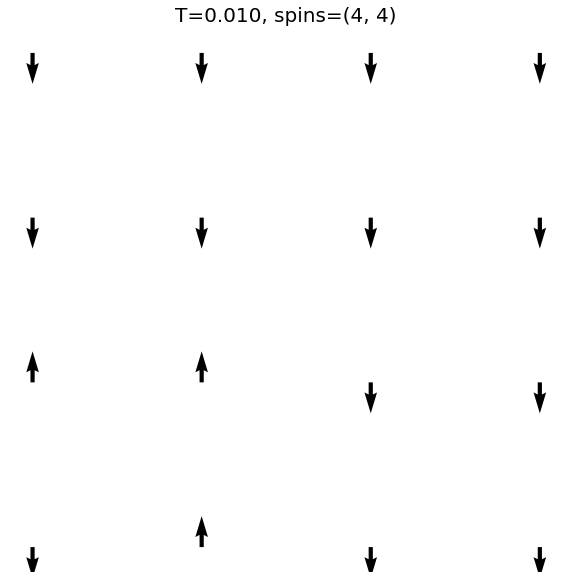

In [43]:
spin_viz()

In [46]:
time_start = time.time()
grid, energy_array, m2_array = chain_evolution(grid, 1000000)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

Time used for 1E5 steps is: 46.611979246139526.


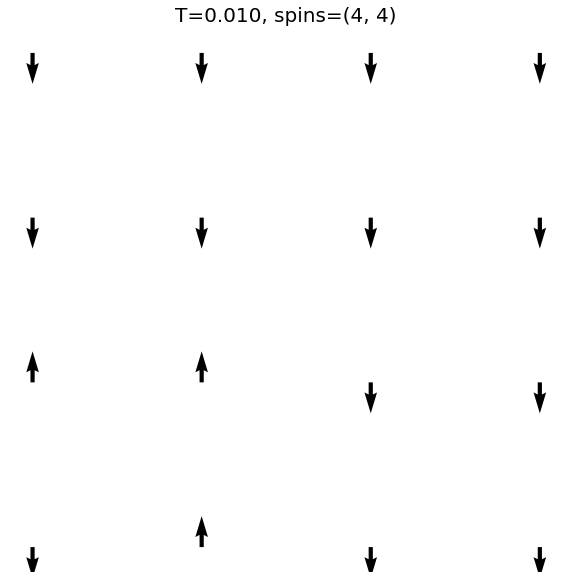

In [47]:
spin_viz()

Text(0.5, 1.0, 'Energy Series of Cluster Evoluation')

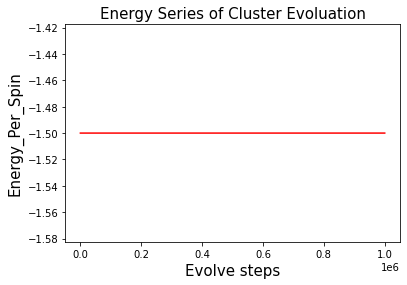

In [48]:
plt.plot(energy_array, '-r')
plt.xlabel("Evolve steps", fontsize=15)
plt.ylabel("Energy_Per_Spin", fontsize=15)
plt.title("Energy Series of Cluster Evoluation", fontsize=15)

Text(0.5, 1.0, 'Energy Series of Cluster Evoluation')

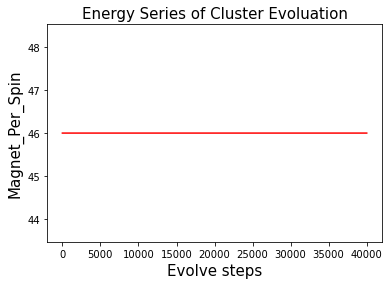

In [49]:
plt.plot(m2_array[:40000], '-r')
plt.xlabel("Evolve steps", fontsize=15)
plt.ylabel("Magnet_Per_Spin", fontsize=15)
plt.title("Energy Series of Cluster Evoluation", fontsize=15)

----